# ROCm GPU Cache Benchmark - End-to-End Demo

This notebook demonstrates the complete workflow of rocmGPUBenches:
1. ✅ Running GPU cache benchmarks
2. 💾 Storing results in SQLite database
3. 🔍 Querying and analyzing data
4. 📊 Visualizing performance with KB/MB formatting
5. 🎯 Cache hierarchy analysis

**Requirements**: AMD GPU with ROCm, Python 3.12+, rocmGPUBenches installed

## 1. Import Required Libraries

Import rocmGPUBenches components and visualization tools.

In [1]:
# Core rocmGPUBenches imports
from rocmGPUBenches import (
    BenchmarkDB,
    create_cache_benchmark_runner,
    plot_sweep,
    plot_comparison,
    plot_gpu_comparison_sweep,
    format_data_size_axis
)

# Visualization
import matplotlib.pyplot as plt
import pandas as pd

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

print("✅ Imports successful!")

✅ Imports successful!


## 2. Setup Benchmark Environment

Initialize the database and benchmark runner, detect GPU.

In [2]:
# Initialize database
db = BenchmarkDB('demo_results.db')
print(f"Database: demo_results.db")
print(f"Stats: {db.stats()}")

# Create benchmark runner
runner = create_cache_benchmark_runner()

# Get GPU information
gpu_name = runner.get_device_name()
gpu_info = {'name': gpu_name, 'arch': 'gfx942'}  # Update arch for your GPU

benchmark_description = (
    "GPU Cache Benchmark: Measures memory bandwidth across the cache hierarchy. "
    "This benchmark performs repeated reads from global memory to characterize "
    "L1, L2, L3/Infinity Cache, and HBM performance at different data volumes."
)

print(f"\n✅ Benchmark runner initialized")
print(f"   Benchmark: cache")
print(f"   Description: {benchmark_description}")
print(f"   GPU: {gpu_name}")
print(f"   Architecture: {gpu_info['arch']}")

Database: demo_results.db
Stats: {'total_results': np.int64(18), 'benchmarks': ['cache'], 'gpus': ['AMD Instinct MI325X'], 'date_range': {'first': '2025-10-17T10:59:43.719920', 'last': '2025-10-17T11:04:39.332458'}}

✅ Benchmark runner initialized
   Benchmark: cache
   Description: GPU Cache Benchmark: Measures memory bandwidth across the cache hierarchy. This benchmark performs repeated reads from global memory to characterize L1, L2, L3/Infinity Cache, and HBM performance at different data volumes.
   GPU: AMD Instinct MI325X
   Architecture: gfx942
Registered benchmark: cache


## 3. Run Single Benchmark

Execute a single cache benchmark to understand the basic workflow.

In [4]:
# Run single benchmark
problem_size = 1024
result = runner.run('cache', {'problem_size': problem_size})

size_bytes = problem_size * 4
size_kb = size_bytes / 1024

print(f"Benchmark: cache")
print(f"Problem size: {problem_size} elements ({size_bytes} bytes, {size_kb:.2f} KB)")
print(f"\nResults:")
print(f"  Primary metric: {result.primary_metric:.2f} {result.metric_name}")
print(f"  Spread: {result.spread_percent:.2f}%")

# Save to database
db.save_result(
    'cache',
    result,
    params={'problem_size': problem_size, 'block_size': 256},
    gpu_info=gpu_info
)
print(f"\n✅ Result saved to database")

Benchmark: cache
Problem size: 1024 elements (4096 bytes, 4.00 KB)

Results:
  Primary metric: 25244.30 bandwidth_gbs
  Spread: 0.89%
Compiling cache kernel with optimizations (one-time compilation)...
Compile flags: -O3 -ffast-math --gpu-max-threads-per-block=1024
Kernel compilation complete! Loaded 2 kernel functions.

✅ Result saved to database


## 4. Run Parameter Sweep

Sweep across different problem sizes to analyze cache hierarchy behavior.

In [5]:
# Define sweep parameters (powers of 2 for clean cache analysis)
sizes = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

size_bytes_min = sizes[0] * 4
size_bytes_max = sizes[-1] * 4

print(f"Running parameter sweep: {len(sizes)} sizes")
print(f"Range: {sizes[0]} to {sizes[-1]} elements")
print(f"Memory: {size_bytes_min} bytes ({size_bytes_min/1024:.3f} KB) to {size_bytes_max} bytes ({size_bytes_max/1024:.1f} KB)\n")

results = []
for size in sizes:
    result = runner.run('cache', {'problem_size' :size})

    # Save to database
    db.save_result(
        'cache',
        result,
        params={'problem_size': size, 'block_size': 256},
        gpu_info=gpu_info
    )

    results.append(result)
    size_bytes = size * 4
    size_kb = size_bytes / 1024
    print(f"  {size:5d} elements ({size_bytes:6d} bytes, {size_kb:7.2f} KB): {result.primary_metric:8.2f} GB/s")

print(f"\n✅ Sweep complete: {len(results)} results saved")

Running parameter sweep: 19 sizes
Range: 64 to 16777216 elements
Memory: 256 bytes (0.250 KB) to 67108864 bytes (65536.0 KB)

     64 elements (   256 bytes,    0.25 KB):  5409.15 GB/s
    128 elements (   512 bytes,    0.50 KB): 10846.39 GB/s
    256 elements (  1024 bytes,    1.00 KB): 21692.01 GB/s
    512 elements (  2048 bytes,    2.00 KB): 24123.56 GB/s
   1024 elements (  4096 bytes,    4.00 KB): 25699.18 GB/s
   2048 elements (  8192 bytes,    8.00 KB): 15915.73 GB/s
   4096 elements ( 16384 bytes,   16.00 KB): 16066.56 GB/s
   8192 elements ( 32768 bytes,   32.00 KB): 16394.80 GB/s
  16384 elements ( 65536 bytes,   64.00 KB): 16428.00 GB/s
  32768 elements (131072 bytes,  128.00 KB): 16335.92 GB/s
  65536 elements (262144 bytes,  256.00 KB): 16340.26 GB/s
  131072 elements (524288 bytes,  512.00 KB): 16351.64 GB/s
  262144 elements (1048576 bytes, 1024.00 KB):  8387.95 GB/s
  524288 elements (2097152 bytes, 2048.00 KB):  8377.64 GB/s
  1048576 elements (4194304 bytes, 4096.00 

## 5. Query and Analyze Results

Use the database to query and aggregate benchmark data.

In [6]:
# Query raw results
df_raw = db.query(benchmark='cache')
print(f"Raw query: {len(df_raw)} results")
print("\nSample data:")
print(df_raw[['timestamp', 'problem_size', 'primary_metric', 'spread_percent']].tail(5))

# Get aggregated sweep data
df_sweep = db.get_sweep_data('cache', 'problem_size')
print(f"\nAggregated sweep data: {len(df_sweep)} points")
print(df_sweep[['problem_size', 'bandwidth_gbs_mean', 'bandwidth_gbs_std', 'run_count']])

Raw query: 38 results

Sample data:
                    timestamp  problem_size  primary_metric  spread_percent
33 2025-10-17 11:00:53.311666          4096    16106.708527        0.889288
34 2025-10-17 11:00:44.184312          1024    25210.839456        0.584610
35 2025-10-17 11:00:38.362185           256    21849.667434        1.027285
36 2025-10-17 11:00:31.627894            64     5408.132566        0.102443
37 2025-10-17 10:59:43.719920          1024    25246.196717        0.934398

Aggregated sweep data: 19 points
    problem_size  bandwidth_gbs_mean  bandwidth_gbs_std  run_count
0             64         5407.842569           1.209094          4
1            128        10846.393125                NaN          1
2            256        21901.988171         281.680923          4
3            512        24123.559026                NaN          1
4           1024        25301.204217         195.945174          6
5           2048        15915.732404                NaN          1
6    

## 6. Visualize Performance - Sweep Plot

Create a line plot showing bandwidth across problem sizes with KB/MB formatting.

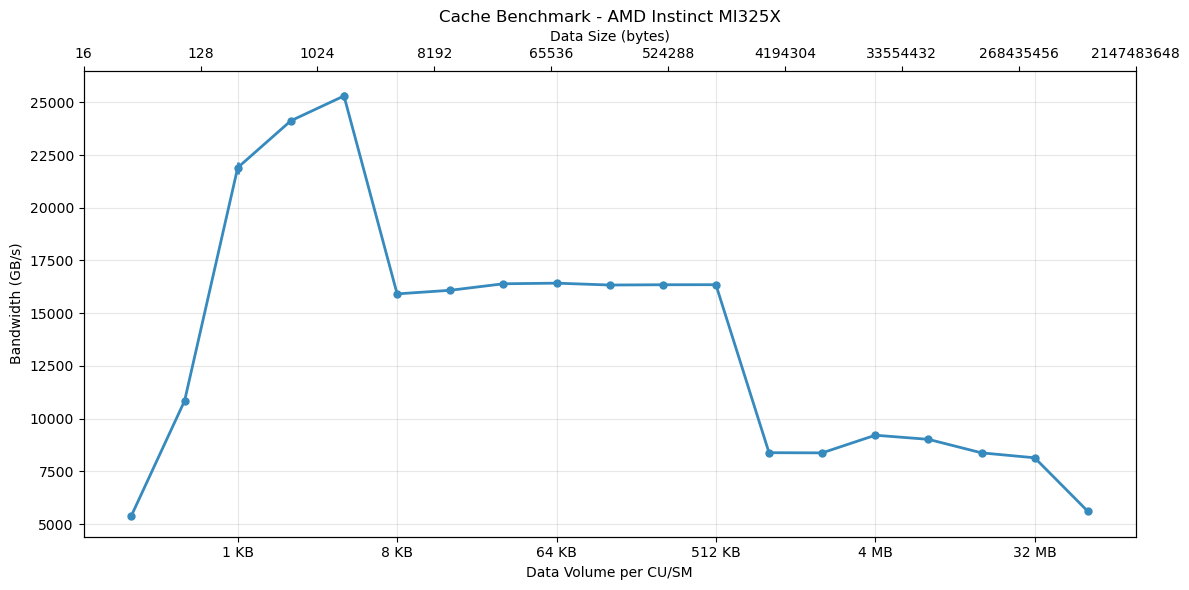


✅ Sweep plot with KB/MB and bytes formatting


In [7]:
# Create sweep plot with bytes on secondary x-axis
fig = plot_sweep(
    df_sweep,
    x='problem_size',
    y='bandwidth_gbs_mean',
    yerr='bandwidth_gbs_std',
    title=f'Cache Benchmark - {gpu_name}',
    xlabel='Problem Size (elements)',
    ylabel='Bandwidth (GB/s)',
    xscale='log2',
    figsize=(12, 6),
    show=False
)

# Add KB/MB formatting to x-axis
ax = fig.axes[0]
format_data_size_axis(ax, base_unit_bytes=4)
ax.set_xlabel('Data Volume per CU/SM')

# Add secondary x-axis showing bytes
ax2 = ax.twiny()
ax2.set_xscale('log', base=2)
ax2.set_xlim(ax.get_xlim())
# Convert element positions to bytes
xticks = ax.get_xticks()
ax2.set_xticks(xticks)
ax2.set_xticklabels([f'{int(x*4)}' for x in xticks])
ax2.set_xlabel('Data Size (bytes)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Sweep plot with KB/MB and bytes formatting")

## 7. Visualize Performance - Comparison Plot

Bar chart comparing bandwidth across different problem sizes.

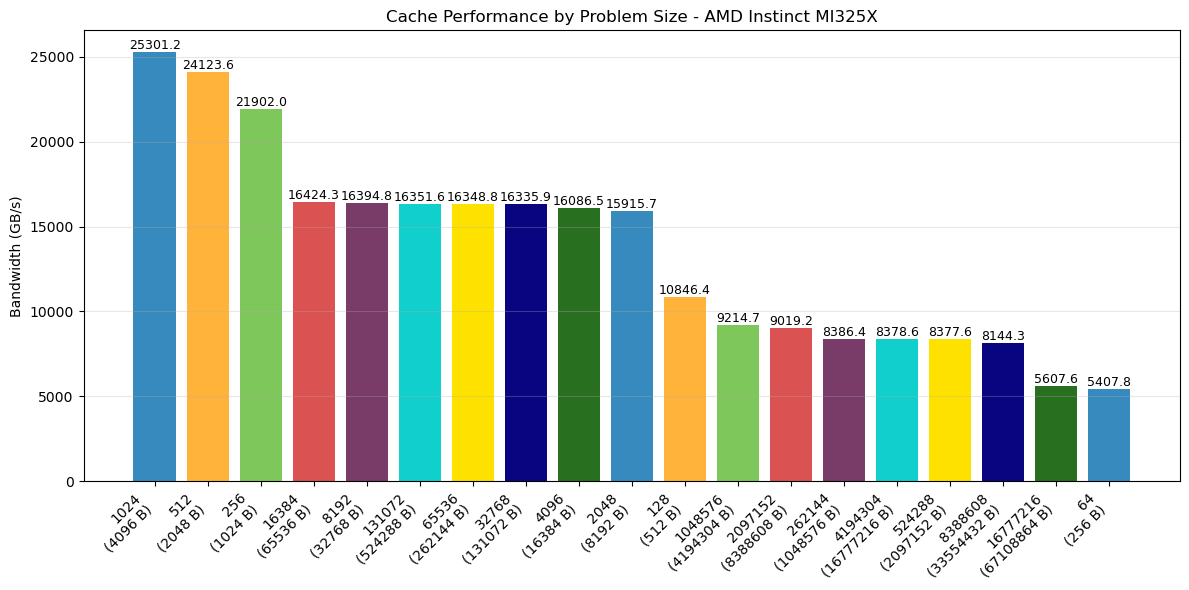


✅ Comparison bar chart (ordered by problem size, showing bytes)


In [8]:
# Create comparison bar chart ordered by problem size
# Sort data by problem_size to show memory hierarchy clearly
df_sorted = df_raw.sort_values('problem_size')

fig = plot_comparison(
    df_sorted,
    metric='primary_metric',
    group_by='problem_size',
    title=f'Cache Performance by Problem Size - {gpu_name}',
    ylabel='Bandwidth (GB/s)',
    figsize=(12, 6),
    show=False
)

# Add bytes to x-axis labels
ax = fig.axes[0]
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [f'{label}\n({int(float(label))*4} B)' for label in labels]
ax.set_xticklabels(new_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✅ Comparison bar chart (ordered by problem size, showing bytes)")

## 8. Cache Hierarchy Analysis

Analyze the results to identify cache levels based on performance cliffs.

**Cache Hierarchy Overview:**
- **L1 Cache**: Per-CU, smallest & fastest (~32-64 KB per CU)
- **L2 Cache**: Shared across CUs, medium size (~4-8 MB total)
- **L3/Infinity Cache**: Large last-level cache on CDNA3 (256+ MB)
- **HBM (Main Memory)**: High bandwidth memory, highest latency

As data size increases, we expect to see "performance cliffs" where bandwidth drops as we exceed each cache level's capacity.

In [9]:
# Analyze cache hierarchy from bandwidth data
df_analysis = df_sweep.copy()
df_analysis['data_size_bytes'] = df_analysis['problem_size'] * 4
df_analysis['data_size_kb'] = df_analysis['data_size_bytes'] / 1024
df_analysis['data_size_mb'] = df_analysis['data_size_kb'] / 1024

print("Cache Hierarchy Analysis:")
print("=" * 85)
print(f"{'Size (bytes)':>12} {'Size (KB)':>12} {'Size (MB)':>12} {'Bandwidth':>15} {'% Peak':>10} {'Cache Level':>20}")
print("=" * 85)

peak_bw = df_analysis['bandwidth_gbs_mean'].max()
prev_bw = peak_bw

for idx, row in df_analysis.iterrows():
    size_bytes = row['data_size_bytes']
    size_kb = row['data_size_kb']
    size_mb = row['data_size_mb']
    bw = row['bandwidth_gbs_mean']
    pct = (bw / peak_bw) * 100

    # Identify likely cache level based on size thresholds
    # These are approximate for CDNA3 (MI300 series)
    if size_kb < 32:
        cache_level = "L1 Cache"
    elif size_kb < 512:
        cache_level = "L2 Cache"
    elif size_mb < 64:
        cache_level = "L3/Infinity Cache"
    else:
        cache_level = "HBM (Main Memory)"

    # Detect performance cliffs (>10% drop)
    bw_drop = prev_bw - bw
    drop_pct = (bw_drop / prev_bw) * 100 if prev_bw > 0 else 0
    cliff_marker = " ⚠️ CLIFF" if drop_pct > 10 else ""

    print(f"{size_bytes:12d} {size_kb:12.2f} {size_mb:12.4f} {bw:12.2f} GB/s {pct:9.1f}% {cache_level:>20}{cliff_marker}")
    prev_bw = bw

print("=" * 85)
print(f"\nPeak bandwidth: {peak_bw:.2f} GB/s")
print(f"Lowest bandwidth: {df_analysis['bandwidth_gbs_mean'].min():.2f} GB/s")
print(f"Bandwidth ratio (peak/lowest): {peak_bw / df_analysis['bandwidth_gbs_mean'].min():.2f}x")
print(f"\n💡 Interpretation:")
print("   - Higher bandwidth at small sizes indicates L1/L2 cache performance")
print("   - Performance cliffs (⚠️) show transitions between cache levels")
print("   - CDNA3 Infinity Cache provides high bandwidth up to ~64 MB")
print("   - HBM bandwidth is still excellent but lower than cache")

Cache Hierarchy Analysis:
Size (bytes)    Size (KB)    Size (MB)       Bandwidth     % Peak          Cache Level
         256         0.25       0.0002      5407.84 GB/s      21.4%             L1 Cache ⚠️ CLIFF
         512         0.50       0.0005     10846.39 GB/s      42.9%             L1 Cache
        1024         1.00       0.0010     21901.99 GB/s      86.6%             L1 Cache
        2048         2.00       0.0020     24123.56 GB/s      95.3%             L1 Cache
        4096         4.00       0.0039     25301.20 GB/s     100.0%             L1 Cache
        8192         8.00       0.0078     15915.73 GB/s      62.9%             L1 Cache ⚠️ CLIFF
       16384        16.00       0.0156     16086.45 GB/s      63.6%             L1 Cache
       32768        32.00       0.0312     16394.80 GB/s      64.8%             L2 Cache
       65536        64.00       0.0625     16424.33 GB/s      64.9%             L2 Cache
      131072       128.00       0.1250     16335.92 GB/s      64.6% 

## 9. Export Results

Export data for further analysis or sharing.

**Why export?**
- **Cross-GPU comparison**: Combine results from multiple GPUs/systems for architectural comparison
- **Publication/reporting**: Generate tables and figures for papers or presentations
- **External tools**: Use with spreadsheets, plotting libraries, or statistical analysis tools
- **Long-term archival**: CSV/JSON are portable formats that don't depend on Python/SQLite
- **Data sharing**: Easy to share with colleagues or include in repositories

In [10]:
# Export to CSV for external analysis
csv_file = 'cache_results.csv'
db.export_csv(csv_file)
print(f"✅ Exported to: {csv_file}")
print(f"   Use case: Open in Excel, combine with other GPU results, or process with pandas")

# Can also export to JSON for structured data
json_file = 'cache_results.json'
db.export_json(json_file)
print(f"✅ Exported to: {json_file}")
print(f"   Use case: Web applications, APIs, or language-agnostic data exchange")

# Show database statistics
stats = db.stats()
print(f"\nDatabase Statistics:")
print(f"  Total results: {stats['total_results']}")
print(f"  Benchmarks: {stats['benchmarks']}")
print(f"  GPUs: {stats['gpus']}")
print(f"  Date range: {stats['date_range']['first']} to {stats['date_range']['last']}")
print(f"\n💡 Tip: Run this notebook on different GPUs (MI250X, MI300A, MI300X) and")
print(f"   combine their exported CSV files to create comprehensive comparison plots!")

Exported 38 results to cache_results.csv
✅ Exported to: cache_results.csv
   Use case: Open in Excel, combine with other GPU results, or process with pandas
Exported 38 results to cache_results.json
✅ Exported to: cache_results.json
   Use case: Web applications, APIs, or language-agnostic data exchange

Database Statistics:
  Total results: 38
  Benchmarks: ['cache']
  GPUs: ['AMD Instinct MI325X']
  Date range: 2025-10-17T10:59:43.719920 to 2025-10-17T11:19:36.545332

💡 Tip: Run this notebook on different GPUs (MI250X, MI300A, MI300X) and
   combine their exported CSV files to create comprehensive comparison plots!


## 10. Multi-GPU Comparison (Optional)

If you have results from multiple GPUs, use this to compare them.

In [11]:
# Query all cache results (potentially from multiple GPUs)
df_all = db.query(benchmark='cache')
gpu_count = df_all['gpu_name'].nunique()

print(f"Total cache results: {len(df_all)}")
print(f"Number of GPUs: {gpu_count}")
print(f"GPUs: {df_all['gpu_name'].unique().tolist()}")

if gpu_count > 1:
    # Multi-GPU comparison plot
    fig = plot_gpu_comparison_sweep(
        df_all,
        x='problem_size',
        y='primary_metric',
        title='Cache Hierarchy: GPU Comparison',
        xscale='log2',
        figsize=(14, 7),
        show=True
    )
    print("\n✅ Multi-GPU comparison plot")
else:
    print("\nℹ️  Run benchmarks on multiple GPUs to enable comparison")
    print("   Each GPU's results will be automatically grouped by gpu_name")

Total cache results: 38
Number of GPUs: 1
GPUs: ['AMD Instinct MI325X']

ℹ️  Run benchmarks on multiple GPUs to enable comparison
   Each GPU's results will be automatically grouped by gpu_name


## Summary

This notebook demonstrated:
- ✅ Running GPU cache benchmarks with different problem sizes
- ✅ Automatic storage in SQLite database
- ✅ Flexible querying and data aggregation
- ✅ Multiple visualization types (line plots, bar charts)
- ✅ KB/MB formatting for cache hierarchy analysis
- ✅ Multi-GPU comparison support
- ✅ Data export for external analysis

**Next Steps**:
- Run on different GPUs and compare
- Try other benchmarks (GPU Latency, GPU Stream, etc.)
- Analyze cache hierarchy characteristics
- Explore parameter sweeps with block_size variations